# **Predicting Chest Pain Type from Health Data**

## **Introduction**

Heart disease refers to a group of conditions that affect the heart. As one of the leading causes of death in North America, early diagnosis is crucial to help save lives. Interestingly, chest pain type is linked to heart disease type, thus, classifying chest pain type may be effective in diagnosing heart diseases. Using patients' recorded health data, we will classify chest pain into three categories (anginal, non-anginal, or asymptomatic) to answer the question: How are resting blood pressure, age, and maximum heart rate achieved related to a patient's chest pain type, and how accurately can a patient's chest pain type be predicted with these data? We are using the Heart Disease dataset, containing observations linked to heart diseases, to answer our question. The dataset includes data from Cleveland, Hungary, Switzerland, and VA Long Beach, which we combined into a single data frame.

#### **Abbreviations**
- **KNN:** K-nearest neighbours

## **Preliminary Exploratory Data Analysis**

In [1]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
options(repr.plot.width = 8, repr.plot.height = 8)

sws_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.switzerland.data"
clv_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.cleveland.data"
hgr_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.hungarian.data"
vlb_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.va.data"

cols <- c("age", "sex", "cp_type", "rest_bp", "cholesterol", "fbs", "rest_ecg", "max_hr",
          "exercise_angina", "st_depression", "st_slope", "coloured_vsls", "thal", "heart_disease")
na_vals <- c("", "NA", "?", -9.0)

sws <- read_csv(sws_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Switzerland")
clv <- read_csv(clv_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Cleveland")
hgr <- read_csv(hgr_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Hungary")
vlb <- read_csv(vlb_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "VA Long Beach")

heart_disease_data <- bind_rows(sws, clv, hgr, vlb)

heart_disease_data$sex <- ifelse(heart_disease_data$sex == 0, "female", "male")
heart_disease_data$cp_type <- ifelse(heart_disease_data$cp_type == 1, "anginal",
                                     ifelse(heart_disease_data$cp_type == 2, "anginal",
                                            ifelse(heart_disease_data$cp_type == 3, "non-anginal", "asymptomatic")))
heart_disease_data$rest_ecg <- ifelse(heart_disease_data$rest_ecg == 0, "normal",
                                      ifelse(heart_disease_data$rest_ecg == 1, "abnormality", "hypertrophy"))
heart_disease_data$exercise_angina <- ifelse(heart_disease_data$exercise_angina == 0, "no", "yes")
heart_disease_data$st_slope <- ifelse(heart_disease_data$st_slope == 1, "upsloping",
                                      ifelse(heart_disease_data$st_slope == 2, "flat", "downsloping"))
heart_disease_data$thal <- ifelse(heart_disease_data$thal == 3, "normal",
                                      ifelse(heart_disease_data$thal == 6, "fixed", "reversable"))

heart_disease_data <- heart_disease_data |> mutate(sex = as.factor(sex), cp_type = as.factor(cp_type), fbs = as.factor(fbs), rest_ecg = as.factor(rest_ecg),
                                                   exercise_angina = as.factor(exercise_angina), st_slope = as.factor(st_slope), thal = as.factor(thal),
                                                   heart_disease = as.factor(heart_disease), location = as.factor(location))

head(heart_disease_data)

age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
32,male,anginal,95,0,NA,normal,127,no,0.7,upsloping,NA,NA,1,Switzerland
34,male,asymptomatic,115,0,NA,NA,154,no,0.2,upsloping,NA,NA,1,Switzerland
35,male,asymptomatic,NA,0,NA,normal,130,yes,NA,NA,NA,reversable,3,Switzerland
36,male,asymptomatic,110,0,NA,normal,125,yes,1.0,flat,NA,fixed,1,Switzerland
38,female,asymptomatic,105,0,NA,normal,166,no,2.8,upsloping,NA,NA,2,Switzerland
38,female,asymptomatic,110,0,0,normal,156,no,0.0,flat,NA,normal,1,Switzerland


In [3]:
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = cp_type)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_train)
head(heart_disease_test)

age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
53,male,anginal,120,0,0,normal,95,no,0.0,flat,NA,normal,3,Switzerland
53,male,anginal,130,0,NA,abnormality,120,no,0.7,downsloping,NA,NA,0,Switzerland
55,male,anginal,140,0,NA,abnormality,150,no,0.2,upsloping,NA,NA,0,Switzerland
62,female,anginal,140,0,NA,normal,143,no,0.0,NA,NA,normal,2,Switzerland
62,male,anginal,120,0,NA,hypertrophy,134,no,-0.8,flat,2,NA,1,Switzerland
67,male,anginal,145,0,0,hypertrophy,125,no,0.0,flat,NA,normal,2,Switzerland


age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
32,male,anginal,95,0,NA,normal,127,no,0.7,upsloping,NA,NA,1,Switzerland
34,male,asymptomatic,115,0,NA,NA,154,no,0.2,upsloping,NA,NA,1,Switzerland
38,female,asymptomatic,110,0,0,normal,156,no,0.0,flat,NA,normal,1,Switzerland
38,male,non-anginal,115,0,0,normal,128,yes,0.0,flat,NA,reversable,1,Switzerland
43,male,asymptomatic,100,0,NA,normal,122,no,1.5,downsloping,NA,NA,3,Switzerland
48,male,asymptomatic,115,0,NA,normal,128,no,0.0,flat,NA,fixed,2,Switzerland


In [4]:
anginal_rows_missing_data <- sum(!complete.cases(filter(heart_disease_train, cp_type == "anginal")))
non_anginal_rows_missing_data <- sum(!complete.cases(filter(heart_disease_train, cp_type == "non-anginal")))
asymptomatic_rows_missing_data <- sum(!complete.cases(filter(heart_disease_train, cp_type == "asymptomatic")))

cp_type_summarize <- heart_disease_train |> group_by(cp_type) |>
                        summarize(avg_rest_bp = mean(rest_bp, na.rm = TRUE), avg_max_hr = mean(max_hr, na.rm = TRUE), avg_age = mean(age, na.rm = TRUE), num_cases = n()) |>
                        bind_cols(tibble(rows_missing_data = c(anginal_rows_missing_data, non_anginal_rows_missing_data, asymptomatic_rows_missing_data)))

cp_type_summarize

cp_type,avg_rest_bp,avg_max_hr,avg_age,num_cases,rows_missing_data
<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>
anginal,129.9682,150.9682,50.12727,165,111
asymptomatic,132.2147,129.4775,54.70968,372,93
non-anginal,129.6423,144.9275,52.73203,153,263


This table illustrates distinct differences (although subtle) in average resting blood pressure, maximum heart rate achieved, and age between chest pain types (also showing number of cases and rows missing data from each class). Having multiple predictors with distinct values between classes increases the likelihood of accurate class prediction.

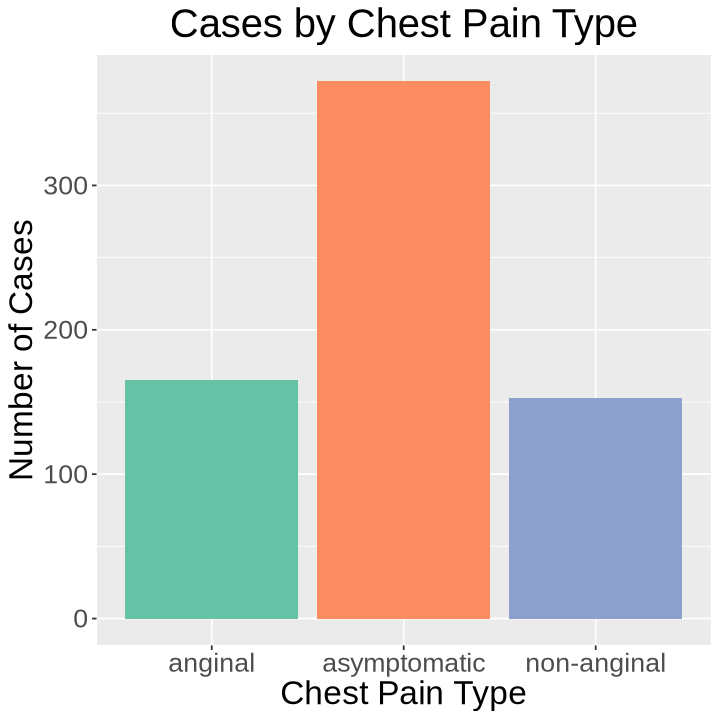

In [5]:
options(repr.plot.width = 6, repr.plot.height= 6)

class_plot <- ggplot(heart_disease_train, aes(x = cp_type, fill = cp_type)) + 
                geom_bar(show.legend = FALSE) +
                labs(x= "Chest Pain Type", y= "Number of Cases") +
                ggtitle("Cases by Chest Pain Type") +
                scale_fill_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
class_plot

This graph shows the imbalance in number of cases of each chest pain type (which will inform our data preprocessing). Anginal and non-anginal cases are quite similar, however, the number of asymptomatic cases is notably larger; the number of anginal and non-anginal cases (individually) are about 40% of the asymptomatic cases.

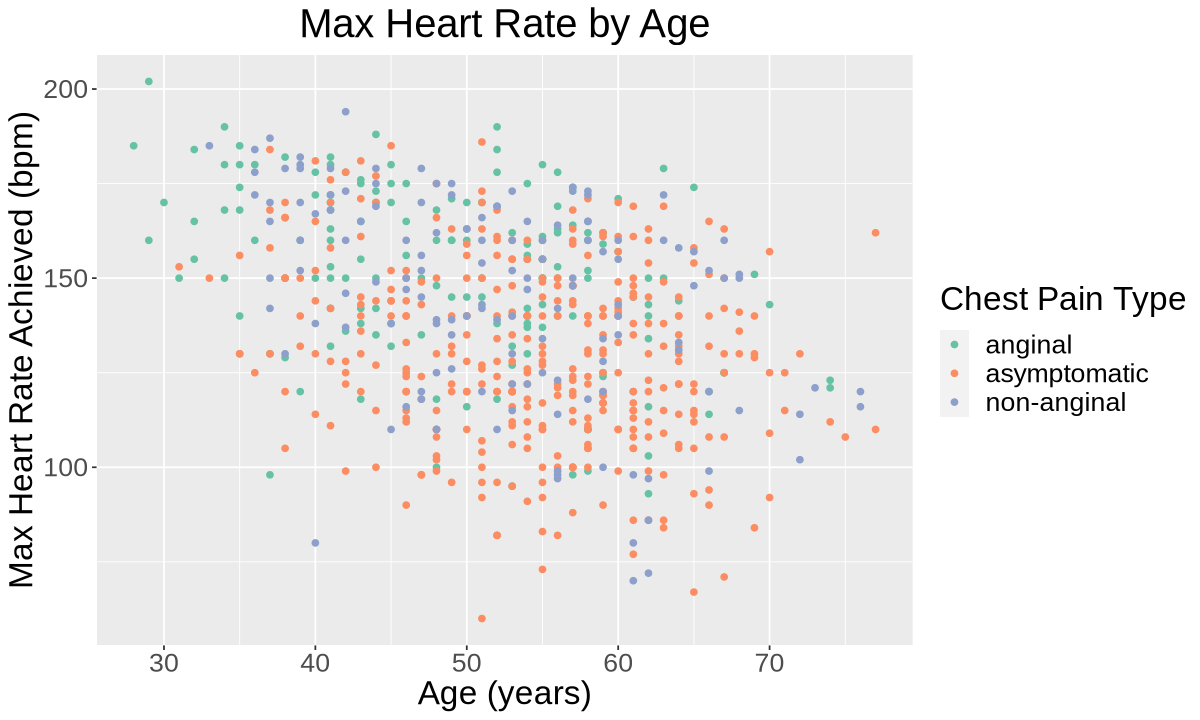

In [6]:
options(repr.plot.width = 10, repr.plot.height= 6)

heart_plot <- heart_disease_train |>
    ggplot(aes(x = age, y = max_hr, color = cp_type)) +
    geom_point() +
    labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
    ggtitle("Max Heart Rate by Age") +
    scale_color_brewer(palette = "Set2") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

suppressWarnings(print(heart_plot))

This plot shows the relationship between max heart rate achieved and age with observations coloured by class to demonstrate the distribution of classes by these predictors. Unfortunately, given the significant overlap in observation coordinate ranges between classes, classes do not seem highly distinguishable by max heart rate achieved and age.

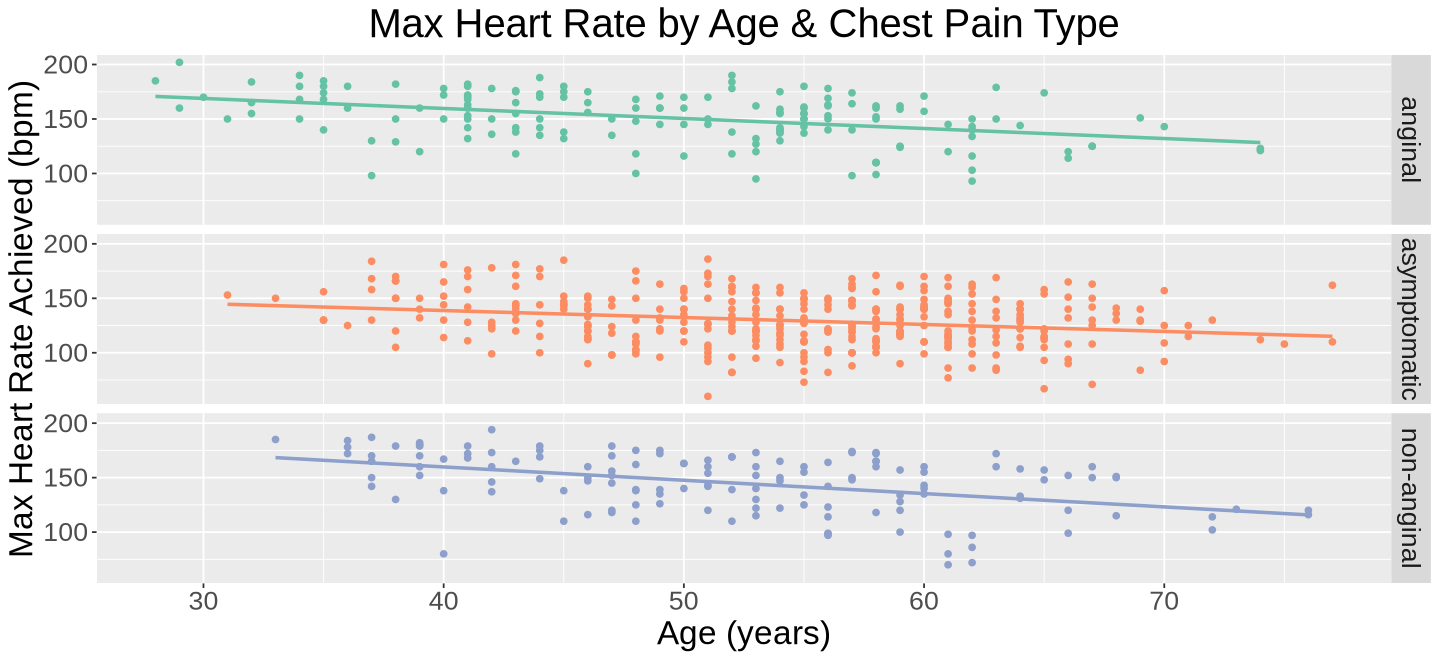

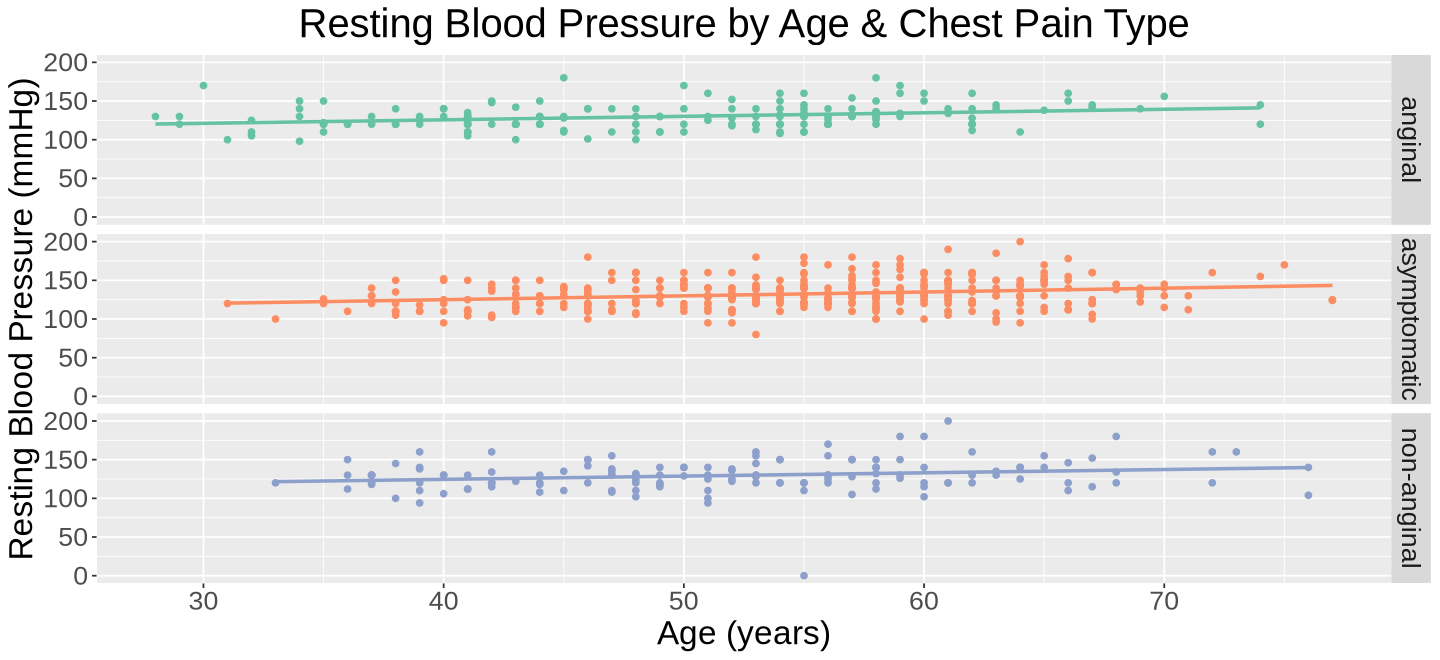

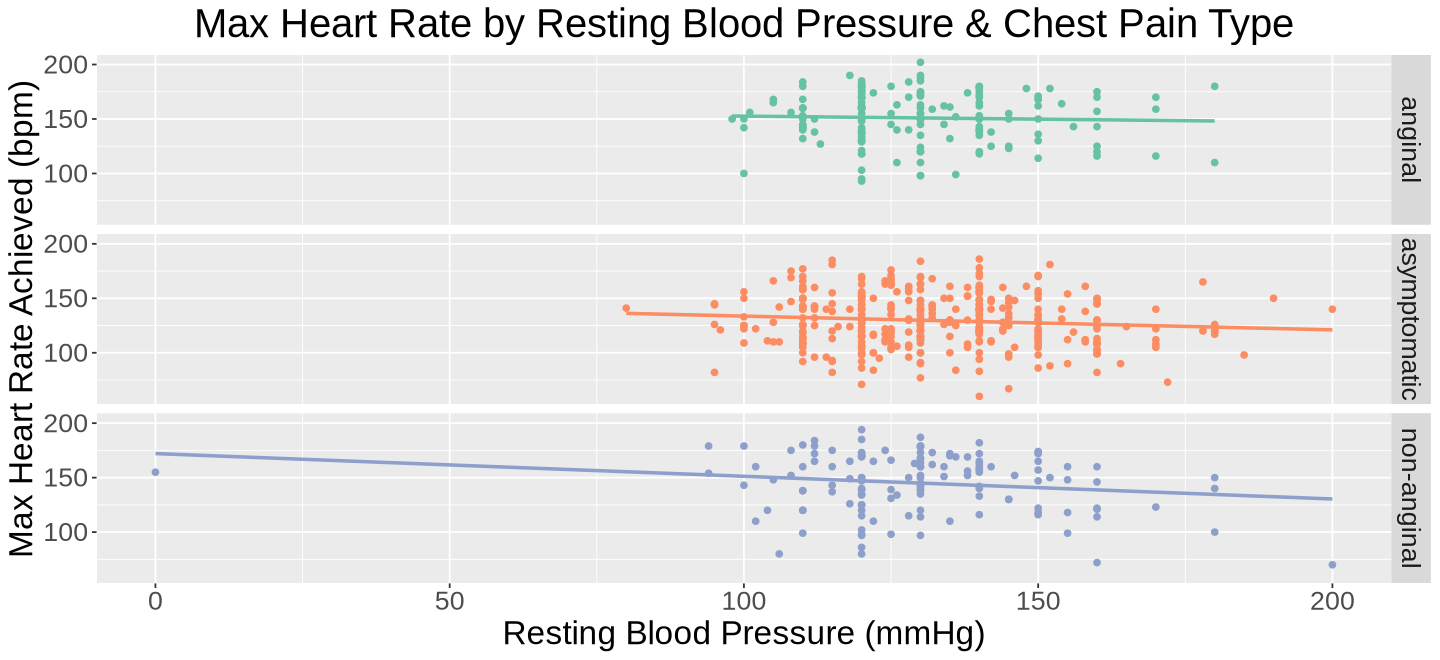

In [7]:
options(repr.plot.width = 12, repr.plot.height = 5.5)

hr_age_plot <- ggplot(heart_disease_train, aes(x = age, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Age & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(hr_age_plot))

bp_age_plot <- ggplot(heart_disease_train, aes(x = age, y = rest_bp, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", color = "Chest Pain Type") +
                ggtitle("Resting Blood Pressure by Age & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(bp_age_plot))

hr_bp_plot <- ggplot(heart_disease_train, aes(x = rest_bp, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Resting Blood Pressure (mmHg)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Resting Blood Pressure & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(hr_bp_plot))

These plots demonstrate the relationships between our predictor variables. Within each plot, the trends for each class are quite similar.

## **Methods**

#### Data Analysis Methods:
Our objective is to classify a person's chest paint type based on their resting blood pressure, age, and maximum heart rate achieved. These variables were chosen as predictors for their distinct quantitative characteristics. Our classifier, which encompasses data preprocessing, model training, and class prediction, will utilize a K-nearest neighbours classification model. Given the absence of a distinct chest pain type of interest, the primary performance metric we will use to evaluate our classifier is accuracy (rather than precision and recall). To maximize classifier performance (i.e., increase accuracy), we will choose the optimal value for K by tuning our model and incorporate cross-validation.


#### Visualizing Our Results:
To visualize how KNN uses distance to classify new observations, we will create annotated scatter plots of our predictor variables with observations coloured by class (and the observation of interest circled). Then, to show how KNN determines class by majority rule, we will create a bar graph showing the number of the observation of interest's neighbours that belong to each class. Finally, to visualize the tuning process, we will produce an accuracy estimate vs. K value line plot, illustrating which K value resulted in the greatest accuracy estimate.

## **Expected Outcomes and Significance**

#### What We Expect to Find:
We expect to find that chest pain type can be predicted with age, maximum heart rate achieved, and resting blood pressure. However, with such subtle differences in predictors between classes, we expect the accuracy (and other metrics) may be low.

#### Potential Impacts Of Our Findings:
Our findings may improve chest pain/heart disease diagnostics. Accurate classification of chest pain types may lead to earlier detection of heart issues leading to more timely treatment and resolution. Furthermore, improved chest pain classification may improve healthcare resource allocation by flagging patients with more urgent needs.

#### Questions Which Could Arise From Our Findings:
1. Which predictor influences the outcome most?
2. Is our classifier accurate and reliable enough for use in real-life healthcare settings?
3. Which other predictors could we have used to better predict chest pain type?